# Ensemble model

In [1]:
from Functions import get_result, get_best_threshold, plot_roc_curve, challenge_champion
import pandas as pd
import pickle
import numpy as np
import xgboost as xgb
from keras.models import load_model
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from mlflow import xgboost, sklearn, keras
from mlflow.tracking import MlflowClient
import json
import mlflow

2025-12-19 16:00:47.113763: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-19 16:00:47.234929: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-19 16:00:47.235004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-19 16:00:47.243412: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-19 16:00:47.279498: I tensorflow/core/platform/cpu_feature_guar

In [2]:
filenames = ['X_train.pkl', 'Y_train.pkl', 'X_val.pkl', 'Y_val.pkl', 'X_test.pkl', 'Y_test.pkl']
data_folder = '../data/'
dataframes = [pd.read_pickle(data_folder + filename) for filename in filenames]
X_train, Y_train, X_val, Y_val, X_test, Y_test = dataframes

In [3]:
# Read the JSON file
with open('../config.json', 'r') as file:
    config = json.load(file)

# Set the tracking URI for logging using the values from the JSON file
mlflow.set_tracking_uri(uri=f"http://{config['host']}:{config['port']}")

client = MlflowClient()

exp_name = "Credit_Card_Approval"
experiment = mlflow.get_experiment_by_name(exp_name)
exp_id = experiment.experiment_id
exp_id

'1'

Lets load the different models we want to use

In [4]:
# Load champion XGBoost model and its best threshold
xgboost_model_name = "Credit_Card_Approval_XGBoost"
xgb = xgboost.load_model(f"models:/{xgboost_model_name}@champion")
xgb_info = client.get_model_version_by_alias(name=xgboost_model_name, alias="champion")
xgb_threshold = float(xgb_info.tags['best_threshold'])

In [5]:
# Load champion Random Forest model and its best threshold
rf_model_name = "Credit_Card_Approval_RandomForest"
rf = sklearn.load_model(f"models:/{rf_model_name}@champion")
rf_info = client.get_model_version_by_alias(name=rf_model_name, alias="champion")
rf_threshold = float(rf_info.tags['best_threshold'])

In [6]:
# Load champion Neural Network model and its best threshold
nn_model_name = "Credit_Card_Approval_Neaural_Network"
nn = keras.load_model(f"models:/{nn_model_name}@champion")
nn_info = client.get_model_version_by_alias(name=nn_model_name, alias="champion")
nn_threshold = float(nn_info.tags['best_threshold'])

2025-12-19 16:01:17.943145: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-19 16:01:18.091452: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-19 16:01:18.091637: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-19 16:01:18.095009: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-19 16:01:18.095106: I external/local_xla/xla/stream_executor

In [7]:
base_models = {xgboost_model_name: xgb, 
               rf_model_name: rf, 
               nn_model_name: nn}

In [8]:
thresholds = {xgboost_model_name: xgb_threshold,
              rf_model_name: rf_threshold,
              nn_model_name: nn_threshold}

Let's create a function, which will take the previously trained models and either use a 'soft'- or a 'hard'-voting method to predict if a customer is a good or risky customer. 
- The soft voting takes each models predicted probability for the customer being risky and finds the average. If the average is above 0.5, the customer is predicted as risky. 
- The hard voting will let each model predict (vote) if a customer is a good or risky customers and the class with the most votes will be the ensemble models prediction.

In [9]:
class EnsembleModel(mlflow.pyfunc.PythonModel):
    """
    Custom MLflow model for the voting ensemble.
    """
    def __init__(self, models, voting_method, model_thresholds=None, soft_threshold=0.5):
        self.models = models
        self.voting_method = voting_method
        self.model_thresholds = model_thresholds
        self.soft_threshold = soft_threshold

    def _predict_proba_for_model(self, model, data):
        """Helper to get probability for different model types."""
        if hasattr(model, 'predict_proba'):
            # For scikit-learn models (XGBoost, RandomForest)
            return model.predict_proba(data)[:, 1]
        else:
            # For Keras models
            return model.predict(data).flatten()

    def predict(self, context, model_input):
        """
        This method generates predictions for the given input.
        """
        if not isinstance(model_input, pd.DataFrame):
             model_input = pd.DataFrame(model_input)

        predictions = {}
        for name, model in self.models.items():
            predictions[name] = self._predict_proba_for_model(model, model_input)

        if self.voting_method == 'soft':
            all_probas = np.array(list(predictions.values()))
            avg_probas = np.mean(all_probas, axis=0)
            final_preds = (avg_probas > self.soft_threshold).astype(int)
            return final_preds
        else: # hard voting
            if self.model_thresholds:
                vote_arr = np.array([(probas > self.model_thresholds[name]).astype(int) for name, probas in predictions.items()])
            else:
                vote_arr = np.array([(probas > 0.5).astype(int) for probas in predictions.values()])

            # Majority vote for each sample
            final_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=vote_arr)
            return final_preds

/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


## Ensemble model with hard voting

Let's take the best thresholds that was found for the different models that was trained

Now let's use the votingClassifier function with the voting set to 'hard'. 

  22/1067 [..............................] - ETA: 2s  

2025-12-19 16:01:21.793231: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1067/1067 [==============================] - 3s 3ms/step


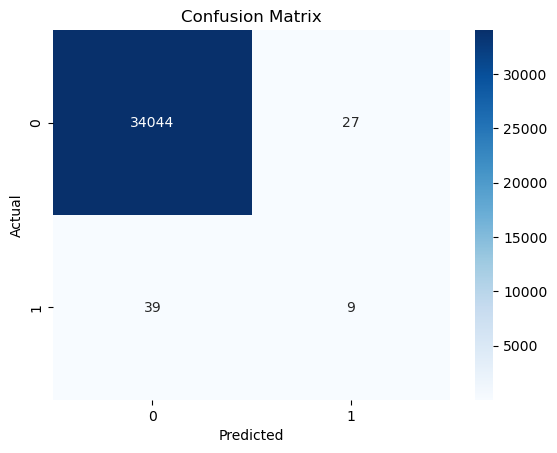

Accuracy     = 1.0
Recall       = 0.19
Precision    = 0.25
F1           = 0.21


2025/12/19 16:01:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Credit_Card_Approval_Ensemble_Hard' already exists. Creating a new version of this model...
2025/12/19 16:01:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Credit_Card_Approval_Ensemble_Hard, version 2
Created version '2' of model 'Credit_Card_Approval_Ensemble_Hard'.


Logged hard voting model to run: 59ba5670f3f348a793de4ce232ac889a
🏃 View run Ensemble_Hard_Voting at: http://127.0.0.1:8080/#/experiments/0/runs/59ba5670f3f348a793de4ce232ac889a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/0


In [ ]:
hard_voting_model_name = "Credit_Card_Approval_Ensemble_Hard"

with mlflow.start_run(run_name="Ensemble_Hard_Voting") as run:
    run_id_hard = run.info.run_id
    # Instantiate the EnsembleModel for hard voting and make predictions
    ensemble_hard_model = EnsembleModel(models=base_models, voting_method='hard', model_thresholds=thresholds)

    # Make predictions using the ensemble model
    test_predictions = ensemble_hard_model.predict(context=None, model_input=X_test)

    result_hard = get_result(Y_test, test_predictions, visualize=True)

    # Log the model, metrics, and parameters
    model_info_hard = mlflow.pyfunc.log_model(
        name=hard_voting_model_name,
        python_model=ensemble_hard_model,
        registered_model_name=hard_voting_model_name
    )
    model_uri_hard = model_info_hard.model_uri
    mlflow.log_metrics(result_hard)
    mlflow.log_params(thresholds)
    print(f"Logged hard voting model to run: {run.info.run_id}")

In [ ]:
challenger = mlflow.register_model(
    model_uri = model_uri_hard, 
    name = hard_voting_model_name, 
    tags={
        "project": "Credit Card Approval",
        "model_family": "EnsembleClassifier"
    }
)

client.set_registered_model_alias(
    name=hard_voting_model_name,
    alias="challenger",
    version=challenger.version
)

Registered model 'Credit_Card_Approval_Ensemble_Hard' already exists. Creating a new version of this model...
2025/12/19 16:01:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Credit_Card_Approval_Ensemble_Hard, version 3
Created version '3' of model 'Credit_Card_Approval_Ensemble_Hard'.


In [12]:
challenge_champion(
    client, 
    algorithm_name = 'ensemble',
    model_name = hard_voting_model_name, 
    X_test = X_test,
    Y_test = Y_test, 
    challenger_metrics = result_hard, 
    competing_metric = 'f1'
)

No existing champion model found.
Setting current model as champion.


Let's also try with the soft voting.

## Ensemble model with soft voting

1067/1067 [==============================] - 3s 3ms/step


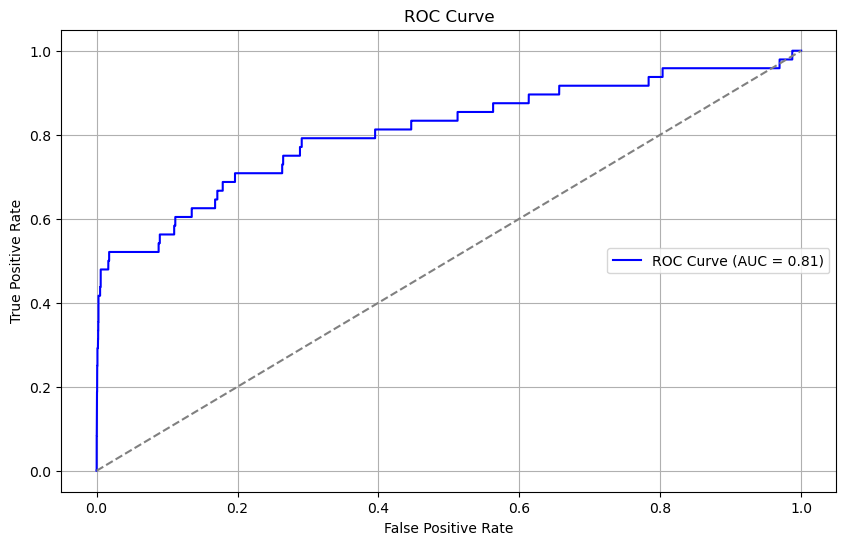

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:77: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


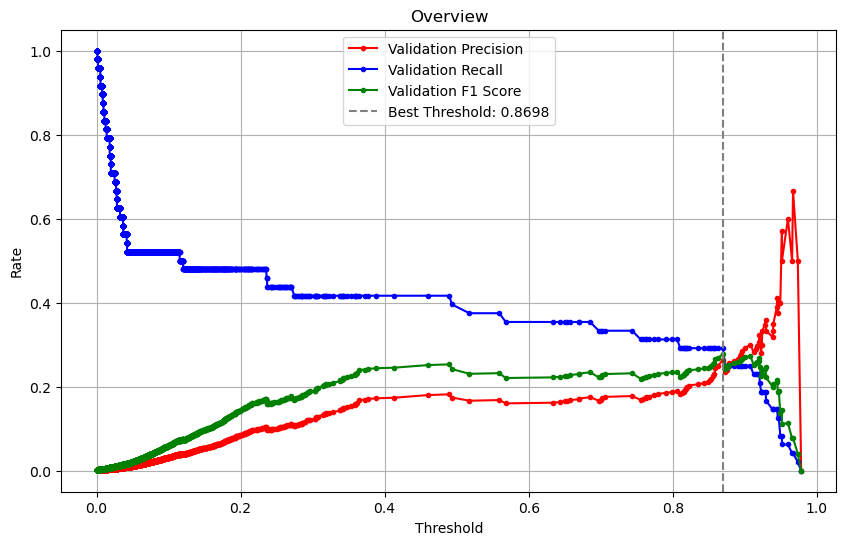

1067/1067 [==============================] - 3s 3ms/step


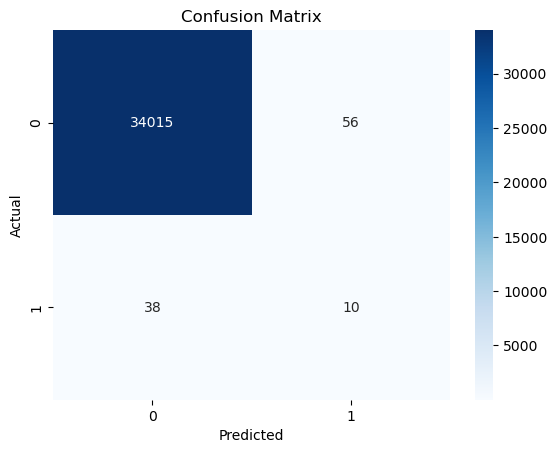

Accuracy     = 1.0
Recall       = 0.21
Precision    = 0.15
F1           = 0.18


2025/12/19 16:14:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Credit_Card_Approval_Ensemble_Soft' already exists. Creating a new version of this model...
2025/12/19 16:14:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Credit_Card_Approval_Ensemble_Soft, version 2
Created version '2' of model 'Credit_Card_Approval_Ensemble_Soft'.


Logged soft voting model to run: fd01eaced24047d08c697bd11727380e
🏃 View run Ensemble_Soft_Voting at: http://127.0.0.1:8080/#/experiments/0/runs/fd01eaced24047d08c697bd11727380e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/0


In [ ]:
soft_voting_model_name = "Credit_Card_Approval_Ensemble_Soft"

with mlflow.start_run(run_name="Ensemble_Soft_Voting") as run:
    run_id_soft = run.info.run_id
    # Instantiate the EnsembleModel for soft voting and make predictions
    ensemble_soft_model_for_thresh = EnsembleModel(models=base_models, voting_method='soft', model_thresholds=thresholds)

    # The predict method for soft voting needs to be temporarily adjusted to return probabilities for threshold finding
    avg_proba = np.mean([ensemble_soft_model_for_thresh._predict_proba_for_model(m, X_val) for m in base_models.values()], axis=0)

    # Find the best threshold
    plot_roc_curve(Y_val, avg_proba)
    best_threshold = get_best_threshold('Validation', Y_val, avg_proba)

    # Now, create the final model with the best threshold to predict on the test set.
    ensemble_soft_model = EnsembleModel(models=base_models, voting_method='soft', soft_threshold=best_threshold)
    test_predictions = ensemble_soft_model.predict(context=None, model_input=X_test)

    # Get the final performance metrics on the test set.
    result_soft = get_result(Y_test, test_predictions, visualize=True)

    # Log the model, metrics, and parameters
    model_info_soft = mlflow.pyfunc.log_model(
        name=soft_voting_model_name,
        python_model=ensemble_soft_model,
        registered_model_name=soft_voting_model_name
    )
    model_uri_soft = model_info_soft.model_uri
    mlflow.log_metrics(result_soft)
    mlflow.log_params(thresholds)
    print(f"Logged soft voting model to run: {run.info.run_id}")

In [14]:
challenger = mlflow.register_model(
    model_uri = model_uri_soft, 
    name = soft_voting_model_name, 
    tags={
        "project": "Credit Card Approval",
        "model_family": "EnsembleClassifier"
    }
)

client.set_registered_model_alias(
    name=soft_voting_model_name,
    alias="challenger",
    version=challenger.version
)

Registered model 'Credit_Card_Approval_Ensemble_Soft' already exists. Creating a new version of this model...
2025/12/19 16:14:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Credit_Card_Approval_Ensemble_Soft, version 3
Created version '3' of model 'Credit_Card_Approval_Ensemble_Soft'.


In [15]:
challenge_champion(
    client, 
    algorithm_name = 'ensemble',
    model_name = soft_voting_model_name, 
    X_test = X_test,
    Y_test = Y_test, 
    challenger_metrics = result_soft, 
    competing_metric = 'f1'
)

No existing champion model found.
Setting current model as champion.
